###Loding the data from the drive -

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


###Importing Necesary Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
import keras
from keras import *
from keras.layers import *
from tensorflow.keras import layers
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

In [4]:
#Let us open and load the pickle files
dataX = pickle.load(open("/content/gdrive/MyDrive/flowAroundObstacles/flowAroundObstaclesX.pkl", "rb"))
dataY = pickle.load(open("/content/gdrive/MyDrive/flowAroundObstacles/flowAroundObstaclesY.pkl", "rb"))

print(dataX.shape)
print(dataY.shape)

(900, 3, 128, 256)
(900, 3, 128, 256)


In [5]:
#Splitting the data into train and test:
X_train, X_test, Y_train, Y_test= train_test_split(dataX, dataY, test_size=0.25, random_state=42)

In [9]:
# Taking only the integer-encoding layer defining input geometry and splitting the three output channels (u,v & p)---

#Training
train_geom  = X_train[:,1,:,:] # Only the second channel is used ---- Integer-Encoded Channel!
u_ori_train = Y_train[:,0,:,:]
v_ori_train = Y_train[:,1,:,:]
p_ori_train = Y_train[:,2,:,:]

#Test
test_geom  = X_test[:,1,:,:] # Only the second channel is used
u_ori_test = Y_test[:,0,:,:]
v_ori_test = Y_test[:,1,:,:]
p_ori_test = Y_test[:,2,:,:]

###Defining a function to display all the channels given an index

In [10]:
# Defining a function for displaying the images --- shape, u profile, v profile and p profile
def display_profile(geom, img_u, img_v, img_p, index):
  plt.figure(figsize=(25,55))

  plt.subplot(1,4,1)
  plt.title("geometry: "+str(index))
  img_shape = geom[index,:,:]
  print(img_shape.shape)
  shape_im = plt.imshow(img_shape, cmap="gray")
  plt.colorbar(shape_im,fraction=0.025, pad=0.05)

  plt.subplot(1,4,2)
  plt.title("u")
  img_u = img_u[index,:,:]
  u_im = plt.imshow(img_u, cmap="jet")
  plt.colorbar(u_im,fraction=0.025, pad=0.05)

  plt.subplot(1,4,3)
  plt.title("v")
  img_v = img_v[index,:,:]
  v_im = plt.imshow(img_v, cmap="jet")
  plt.colorbar(v_im,fraction=0.025, pad=0.05)

  plt.subplot(1,4,4)
  plt.title("p")
  img_p = img_p[index,:,:]
  p_im = plt.imshow(img_p, cmap="jet")
  plt.colorbar(p_im,fraction=0.025, pad=0.05)

(128, 256)
(128, 256)


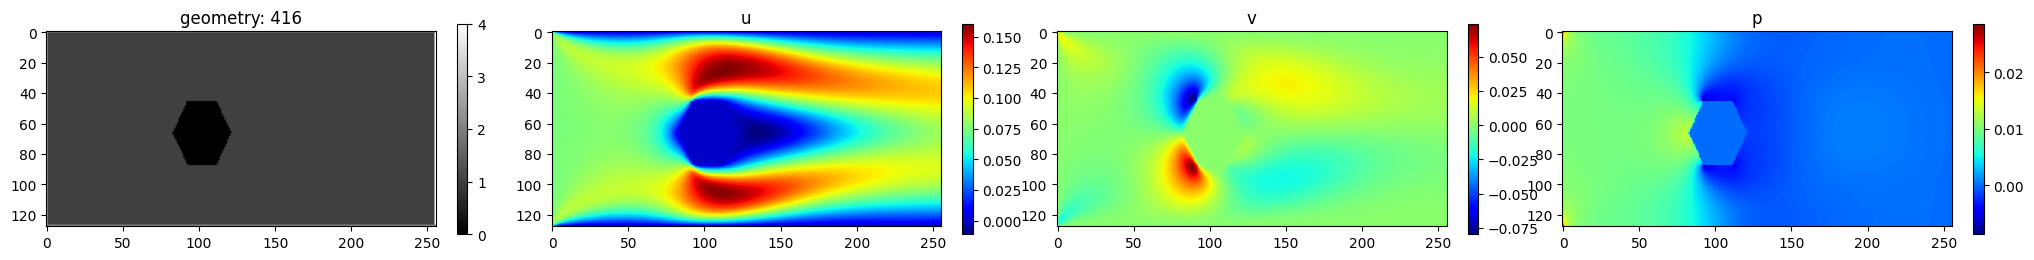

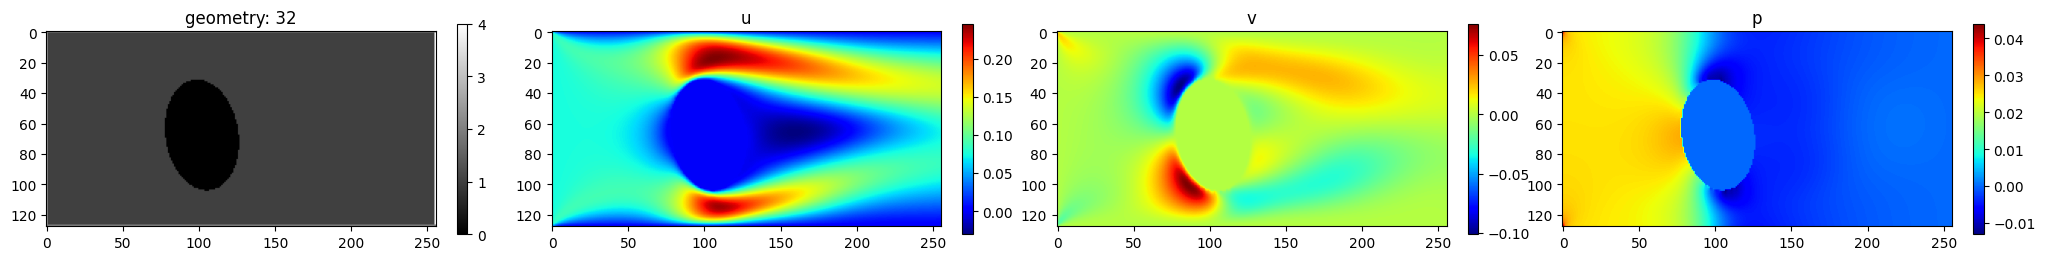

In [11]:
# Displaying a random geometry alomg with its resulting steady state original contours -
# Training
index = np.random.randint(0, train_geom.shape[0])
display_profile(train_geom, u_ori_train, v_ori_train, p_ori_train, index = index)

# Testing
index = np.random.randint(0, test_geom.shape[0])
display_profile(test_geom, u_ori_test, v_ori_test, p_ori_test, index = index)

##### Above code visualizes two random geometries in the input and the corresponding u, v and p profiles (True Labels)

###Plotting the Streamlines

In [12]:
# Define grid points
x_points = np.linspace(0, 255, 256)
y_points = np.linspace(0, 127, 128)
X, Y = np.meshgrid(x_points, y_points)

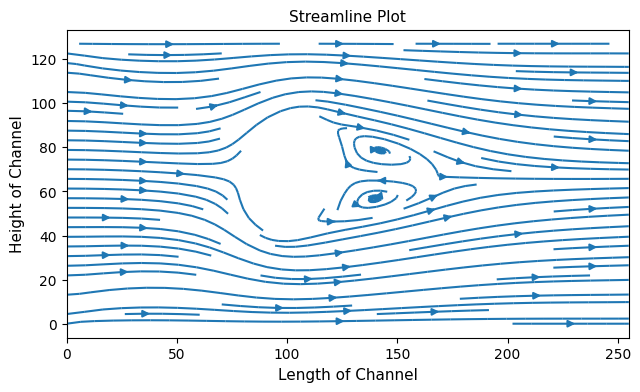

In [13]:
 # StreamLine Plot
num = 5
streamline_plot = plt.figure(figsize = (12,4), edgecolor = "gray")
plt.streamplot(X, Y, dataY[num,0,:,:], dataY[num,1,:,:], density = 1)
plt.axis('scaled')
plt.title("Streamline Plot", fontsize = 11);
plt.xlabel("Length of Channel", fontsize = 11);
plt.ylabel("Height of Channel", fontsize = 11);

###Data Normalization and Processing

In [14]:
#Defining a function that will normalize the contours
def scale(x):
  domain = np.mean(x), np.std(x)
  y = (x - np.mean(x))/(np.std(x))
  return y, domain

In [15]:
# Normalizing the training dataset only -
u_norm, dom_u = scale(u_ori_train) # u profile
v_norm, dom_v = scale(v_ori_train) # v profile
p_norm, dom_p = scale(p_ori_train) # p profile

In [16]:
# dom -- mean, standard deviation as tuple
# Normalizing the test dataset using the mean and standard deviation of the train dataset-
u_test_norm = (u_ori_test - dom_u[0])/dom_u[1]
v_test_norm = (v_ori_test - dom_v[0])/dom_v[1]
p_test_norm = (p_ori_test - dom_p[0])/dom_p[1]

(128, 256)
(128, 256)


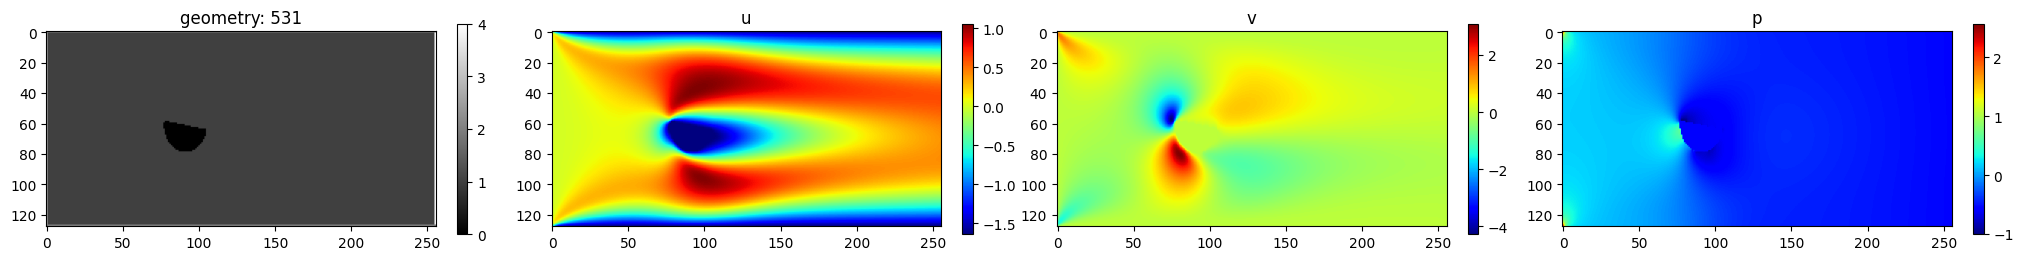

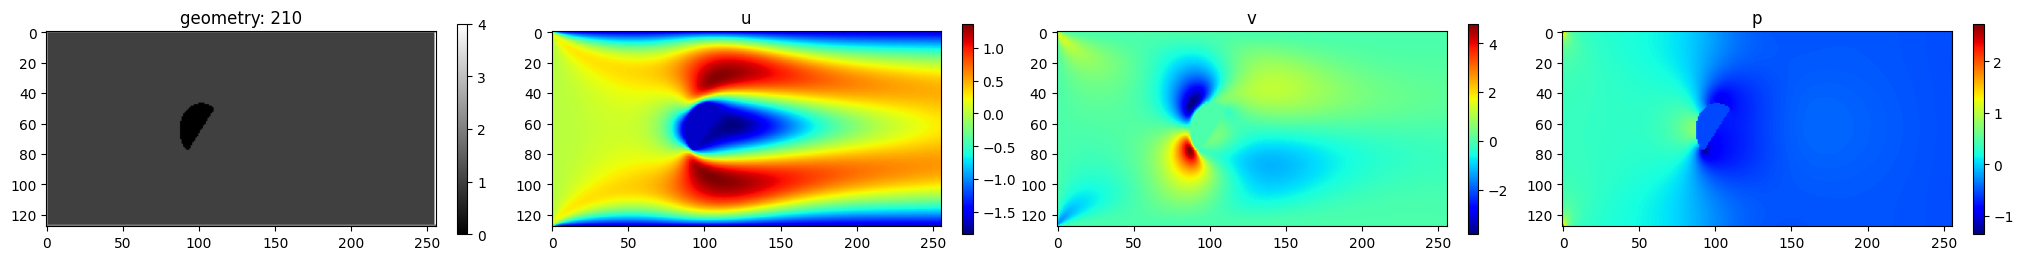

In [18]:
# Displaying a corresponding normalized outputs for the above geometry -
# Normalized Train
index = np.random.randint(0, train_geom.shape[0])
display_profile(train_geom, u_norm, v_norm, p_norm, index = index)
# Normalized Test
index = np.random.randint(0, test_geom.shape[0])
display_profile(test_geom, u_test_norm, v_test_norm, p_test_norm, index = index)

In [19]:
domains = []
for channel in range(3):
  f_norm, dom = scale(dataY[:,channel,:,:])
  domains.append(dict({"profile": channel, "mean": dom[0], "std": dom[1]}))

df = pd.DataFrame(domains, index=None) #saved as scaled props
df

,profile,mean,std
0,0,0.075004,0.046053
1,1,-0.000036,0.013812
2,2,0.004301,0.007917


#####Expanding the dimesnsions so that they can be fed as batches in the CNN training!

In [20]:
def expand_dims_fun(f):
  expanded = np.expand_dims(f, axis = 3) # will increase the dimensions on the image to a batch
  return expanded

# Expanding the dimensions of train dataset
train_geom = expand_dims_fun(train_geom) #Only contains the One Hot Encoding of geometry!
u_train = expand_dims_fun(u_norm)
v_train = expand_dims_fun(v_norm)
p_train = expand_dims_fun(p_norm)

# Expanding the dimensions of test dataset
test_geom = expand_dims_fun(test_geom) #Only contains the One Hot Encoding of geometry!
u_test = expand_dims_fun(u_test_norm)
v_test = expand_dims_fun(v_test_norm)
p_test = expand_dims_fun(p_test_norm)

print(f'Shape of train geom is: {train_geom.shape}')
print(f'Shape of u train profile is: {u_train.shape}')
print(f'Shape of v train profile is: {v_train.shape}')
print(f'Shape of p train profile is: {p_train.shape}')
print()

print(f'Shape of test geom is: {test_geom.shape}')
print(f'Shape of u test profile is: {u_test.shape}')
print(f'Shape of v test profile is: {v_test.shape}')
print(f'Shape of p test profile is: {p_test.shape}')

Shape of train geom is: (675, 128, 256, 1)
Shape of u train profile is: (675, 128, 256, 1)
Shape of v train profile is: (675, 128, 256, 1)
Shape of p train profile is: (675, 128, 256, 1)

Shape of test geom is: (225, 128, 256, 1)
Shape of u test profile is: (225, 128, 256, 1)
Shape of v test profile is: (225, 128, 256, 1)
Shape of p test profile is: (225, 128, 256, 1)


### Visualizing first 225 geometries in the train dataset

<ipython-input-21-dcafac2c8a3b>:6: RuntimeWarning: divide by zero encountered in log
  axes[i, j].imshow(np.log(train_geom[n]), cmap="gray", interpolation=None)


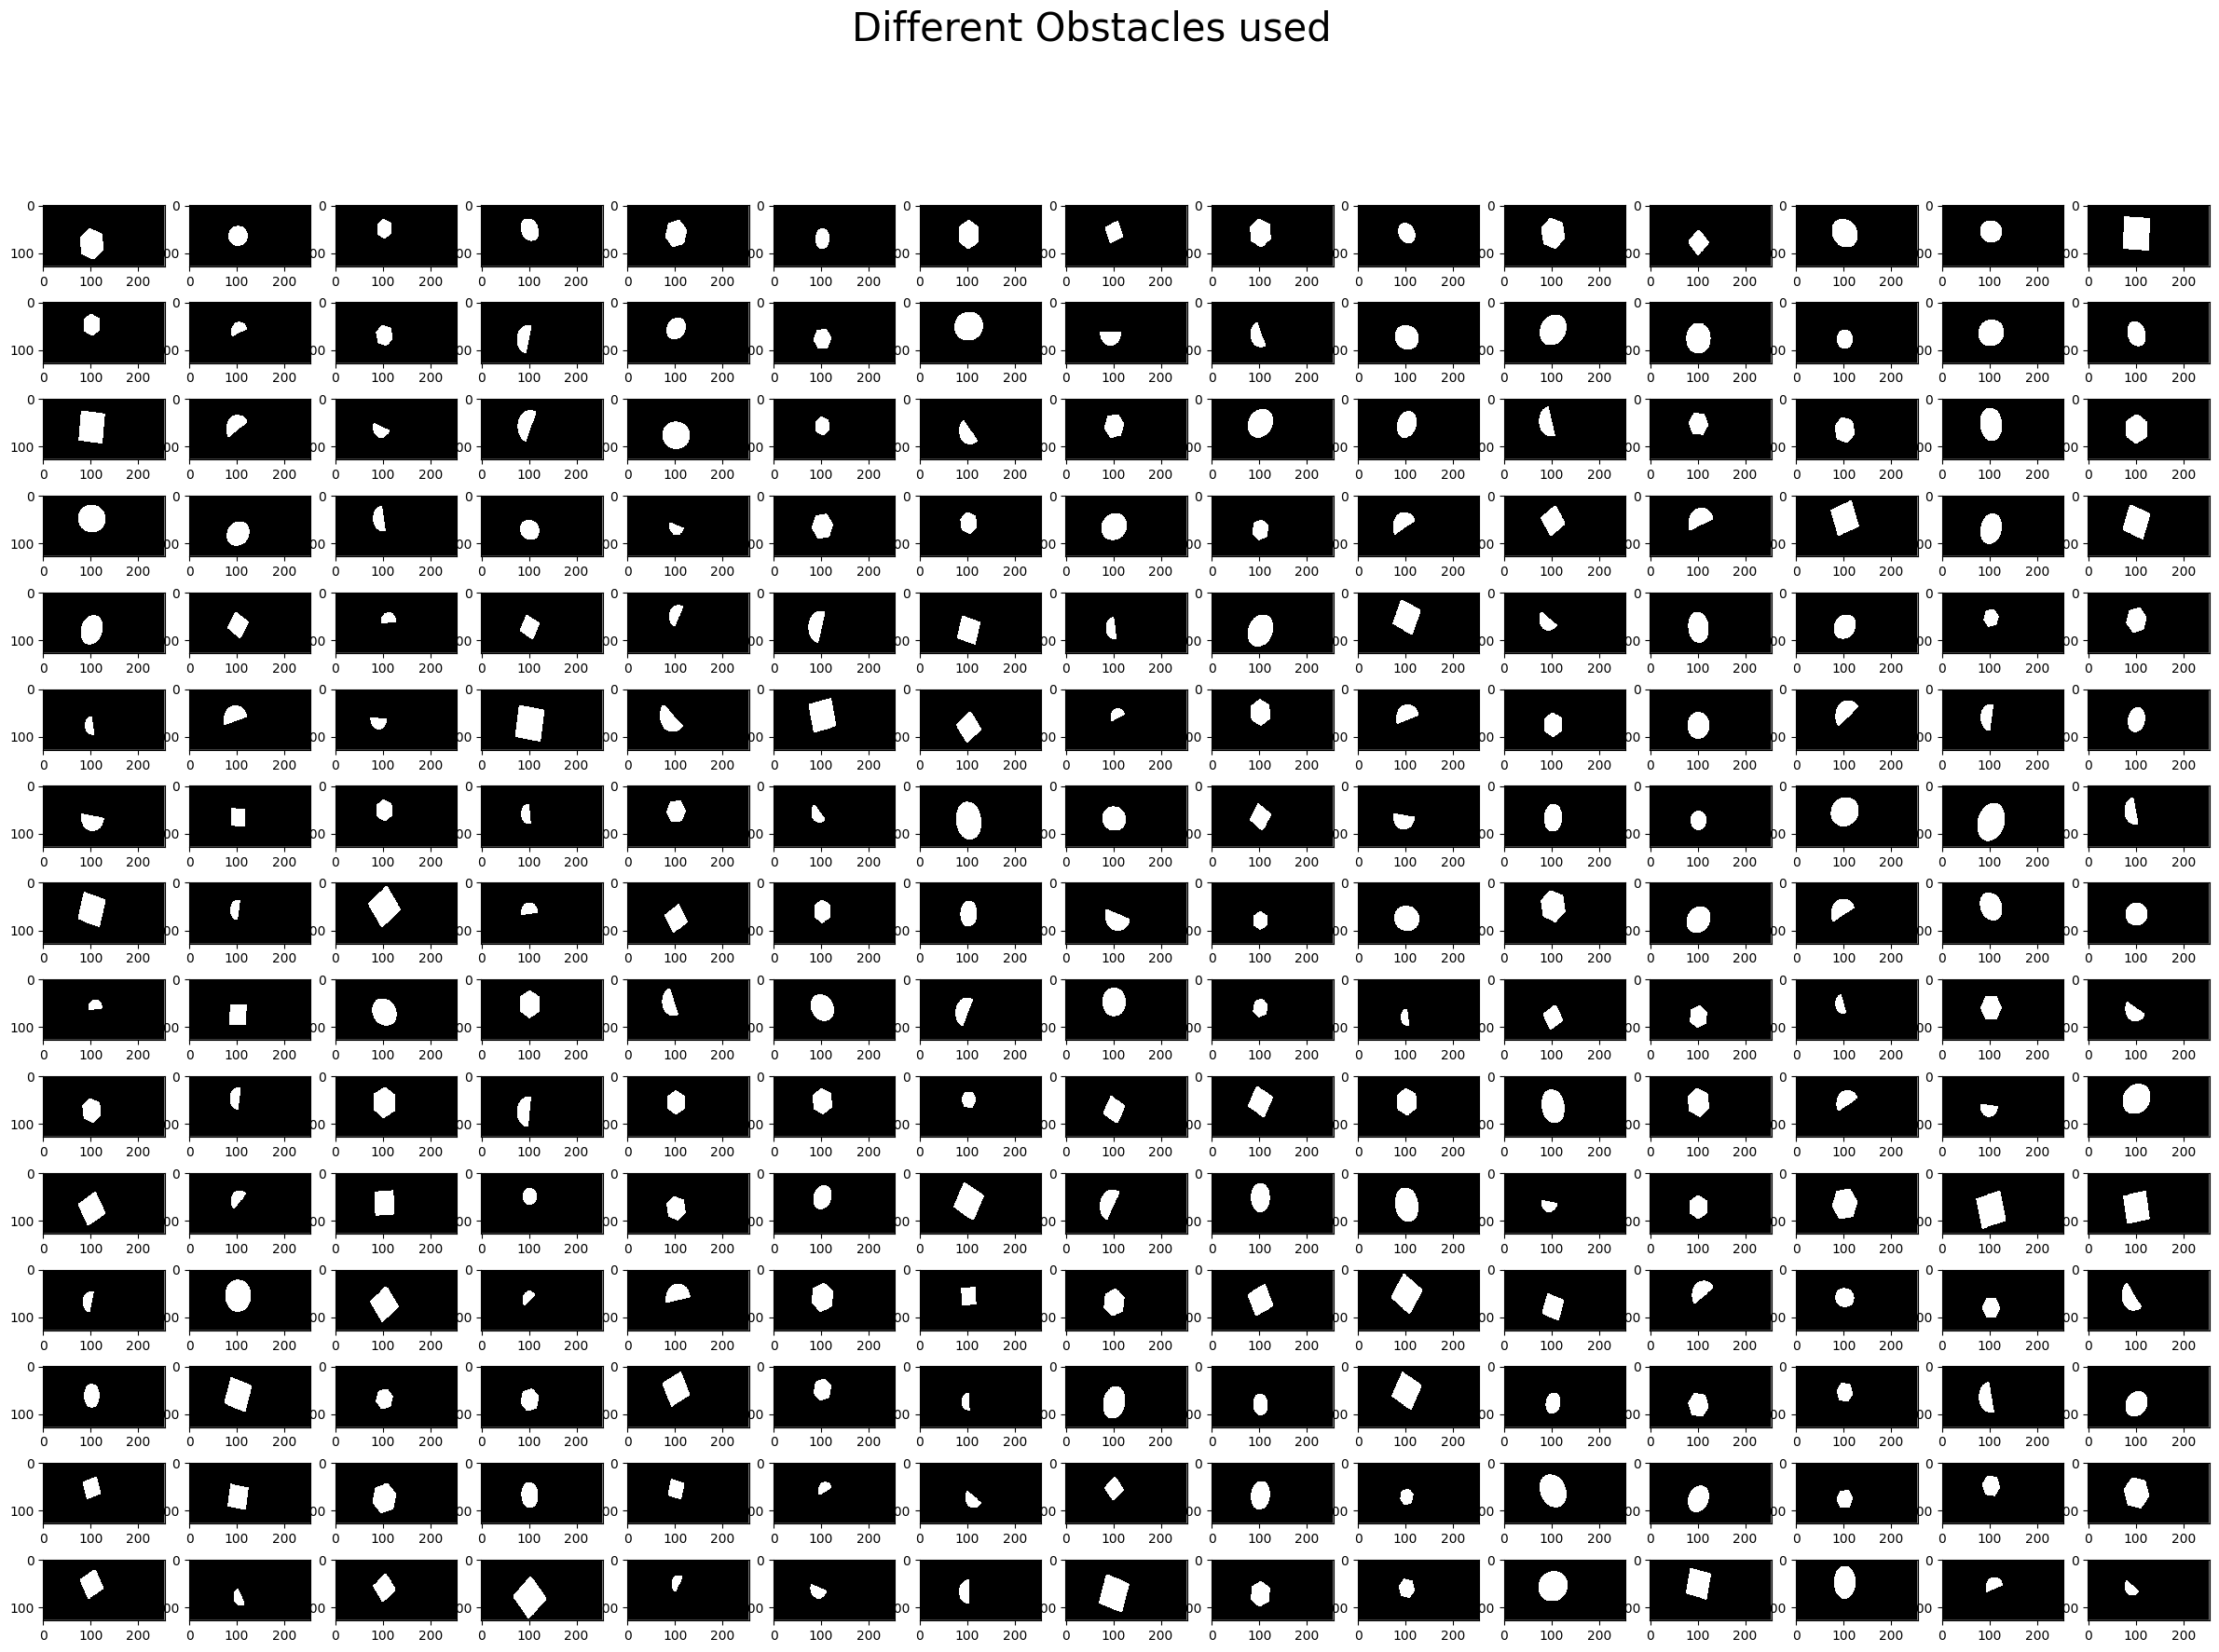

In [21]:
# Visualizing different Obstacle Images used in the Train Dataset - Click Once to zoom in on images-
fig, axes = plt.subplots(nrows = 15, ncols = 15, figsize = (30,20))
n = 0
for i in range(15):
  for j in range(15):
    axes[i, j].imshow(np.log(train_geom[n]), cmap="gray", interpolation=None)
    n += 1
    if n>15*15:
      break

# Add a main title
plt.suptitle("Different Obstacles used", fontsize=30)

# Show the plot
plt.show()

#Model Architecture

In [22]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation, Conv2DTranspose, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.utils import plot_model

####Defining Simple functions for the Encoder and Decoder Blocks!

In [23]:
def conv2d_layers(input, num_filters):
  x = Conv2D(filters = num_filters, kernel_size = (3,3), padding = "same")(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters = num_filters, kernel_size = (3,3), padding = "same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

# Let us now define a function for the Encoder Block. Takes the conv2d_layers function and performs MaxPooling on it!
def encoder_block(input, num_filters):
  x = conv2d_layers(input, num_filters)
  p = MaxPooling2D(pool_size=(2, 2))(x)
  #p = Conv2D(filters = num_filters, strides = (2,2), kernel_size=(2,2))(x)
  return x, p

# Now let us define a Decoder Block. It needs to upconv the late space features, concatinate the skip and upconv, then apply conv2d_layers function!
def decoder_block(inputs, skip_features, num_filters):
  x = Conv2DTranspose(filters = num_filters, kernel_size = (2,2), strides = 2, padding = "same")(inputs)
  x = keras.layers.concatenate([x, skip_features])
  x = conv2d_layers(x, num_filters)
  return x

In [24]:
# Building the basic U-Net Model:
# Output one profile at a time, u, v and p and the finally concatenate them!
output_layers = []
def basic_unet_model(classes, image_height, image_width, channels): #classes = 1
  # Defining the input:
  inputs = Input((image_height, image_width, channels))

  # Defining the Encoding section:
  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)


  # Bridge:
  b1 = conv2d_layers(p4,1024)

  for i in range(3):
  # Decoder:
    d1 = decoder_block(b1,s4,512)
    d2 = decoder_block(d1,s3,256)
    d3 = decoder_block(d2,s2,128)
    d4 = decoder_block(d3,s1,64)

    # Output:
    outputs = Conv2D(filters = classes, kernel_size = 1, padding = "same", activation = 'linear')(d4)
    output_layers.append(outputs)

  # Compiling the Model:
  output_concat = layers.concatenate(output_layers, axis=-1)
  model = Model(inputs=inputs, outputs=output_concat)
  return model

In [25]:
classes = 1
img_H = 128
img_W = 256
channels = 1

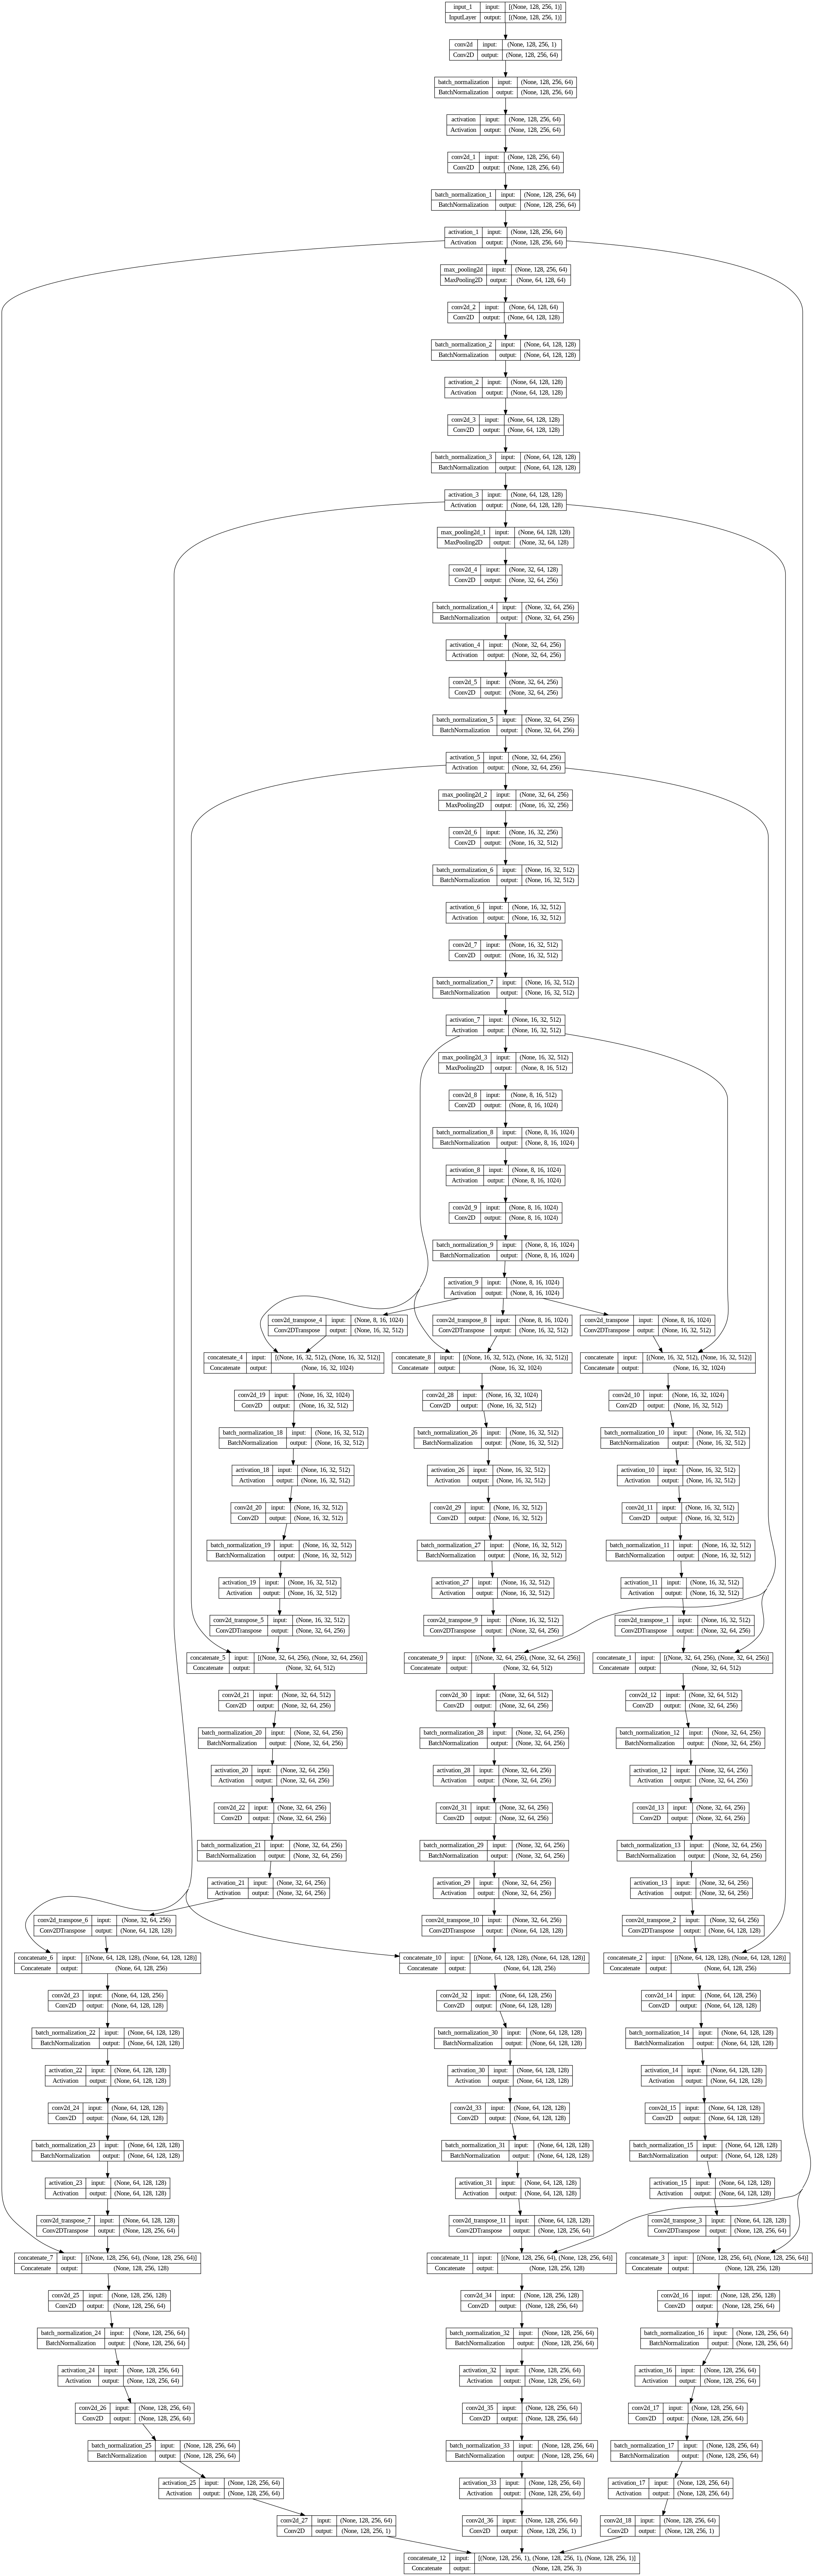

In [26]:
# Build model
model = basic_unet_model(classes, img_H, img_W, channels)
plot_model(model,"model.png",show_shapes=True, show_layer_names=True)

###Defining the Navier Stokes Loss

In [27]:
def nvs_loss(y_pred, rho=1000, nu=0.0001): #arbitary rho and nu - water used
  u,v,p = tf.split(y_pred, 3, axis=3)

  #First order derivative
  du_dx, du_dy = tf.image.image_gradients(u) # tf.image.image_gradients returns a tuple containing two tensors: u-grad along the x dir and u-grad along the y dir
  dv_dx, dv_dy = tf.image.image_gradients(v)
  dp_dx, dp_dy = tf.image.image_gradients(p)

  #Second order derivatives
  du_dx2, du_dydx = tf.image.image_gradients(du_dx) # du_dydx will be unused
  du_dxdy, du_dy2 = tf.image.image_gradients(du_dy) # du_dxdy will be unused

  dv_dx2, dv_dydx = tf.image.image_gradients(dv_dx)
  dv_dxdy, dv_dy2 = tf.image.image_gradients(dv_dy)

  #Momentum equation
  er1_tensor = tf.math.multiply(u, du_dx) + tf.math.multiply(v, du_dy) + 1.0*dp_dx/rho - nu*(du_dx2 + du_dy2)
  er2_tensor = tf.math.multiply(u, dv_dx) + tf.math.multiply(v, dv_dy) + 1.0*dp_dy/rho - nu*(dv_dx2 + dv_dy2)

  # # #Continuity equation
  er3_tensor = du_dx + dv_dy

  er1 = tf.reduce_mean(er1_tensor)
  er2 = tf.reduce_mean(er2_tensor)
  er3 = tf.reduce_mean(er3_tensor)

  return  er1*er1 + er2*er2 + er3*er3

In [28]:
def custom_loss(y_true, y_pred): # frac gives the fraction of the wightage for the individual losses ([0,1])
  frac = 0.5
  nv_loss = nvs_loss(y_pred)
  mse_loss = tf.reduce_mean(tf.square(y_true-y_pred))  # Try mse loss function here
  return frac*mse_loss + (1-frac)*nv_loss

In [29]:
# Compiling the model -
model.compile(loss=custom_loss, optimizer=tf.keras.optimizers.AdamW(learning_rate = 0.0001), metrics=['mae', 'cosine_proximity'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 256, 64)         0         ['batch_normalization[0][0

In [30]:
from keras.callbacks import ModelCheckpoint
filepath = 'Hybrid.h5'
callback_list = [ModelCheckpoint(filepath, save_best_only = True)]

In [31]:
# Let us concatenate the u, v and p channels
y_train = np.concatenate((u_train,v_train,p_train),axis=3)
y_test = np.concatenate((u_test,v_test,p_test),axis=3)
print(f'Shape of the train output is: {y_train.shape}')
print(f'Shape of the test output is: {y_test.shape}')
print()
print(f'Shape of the input geometry is: {train_geom.shape}')
print(f'Shape of the output geometry is: {test_geom.shape}')

Shape of the train output is: (675, 128, 256, 3)
Shape of the test output is: (225, 128, 256, 3)

Shape of the input geometry is: (675, 128, 256, 1)
Shape of the output geometry is: (225, 128, 256, 1)


In [33]:
print(X_train.shape)
print(Y_train.shape)

(675, 3, 128, 256)
(675, 3, 128, 256)


### Training the Physics Informed CNN Model

In [ ]:
pinns_history = model.fit(train_geom, y_train,
                          batch_size=8, epochs=100,
                          validation_data = (test_geom, y_test),
                          shuffle=True, callbacks=[callback_list])

Epoch 1/100
85/85 [==============================] - 112s 827ms/step - loss: 0.2137 - mae: 0.3831 - cosine_proximity: 0.7823 - val_loss: 0.5299 - val_mae: 0.7230 - val_cosine_proximity: 0.0429
Epoch 2/100
85/85 [==============================] - 58s 682ms/step - loss: 0.0638 - mae: 0.2052 - cosine_proximity: 0.9404 - val_loss: 0.5371 - val_mae: 0.7018 - val_cosine_proximity: 0.1215
Epoch 3/100
85/85 [==============================] - 58s 681ms/step - loss: 0.0492 - mae: 0.1770 - cosine_proximity: 0.9519 - val_loss: 0.5416 - val_mae: 0.6866 - val_cosine_proximity: 0.1468
Epoch 4/100
85/85 [==============================] - 69s 809ms/step - loss: 0.0429 - mae: 0.1683 - cosine_proximity: 0.9539 - val_loss: 0.4868 - val_mae: 0.6586 - val_cosine_proximity: 0.2584
Epoch 5/100
85/85 [==============================] - 63s 746ms/step - loss: 0.0410 - mae: 0.1578 - cosine_proximity: 0.9584 - val_loss: 0.4135 - val_mae: 0.6001 - val_cosine_proximity: 0.3830
Epoch 6/100
85/85 [====================

####Predictions

In [ ]:
# Defining a random number and running the prediction on it
num = np.random.randint(0, test_geom.shape[0])

pred = model.predict(np.expand_dims(test_geom[num], axis = 0))
u_pred, v_pred, p_pred = np.split(pred, 3, axis=3)

1/1 [==============================] - 1s 844ms/step


####Visualization

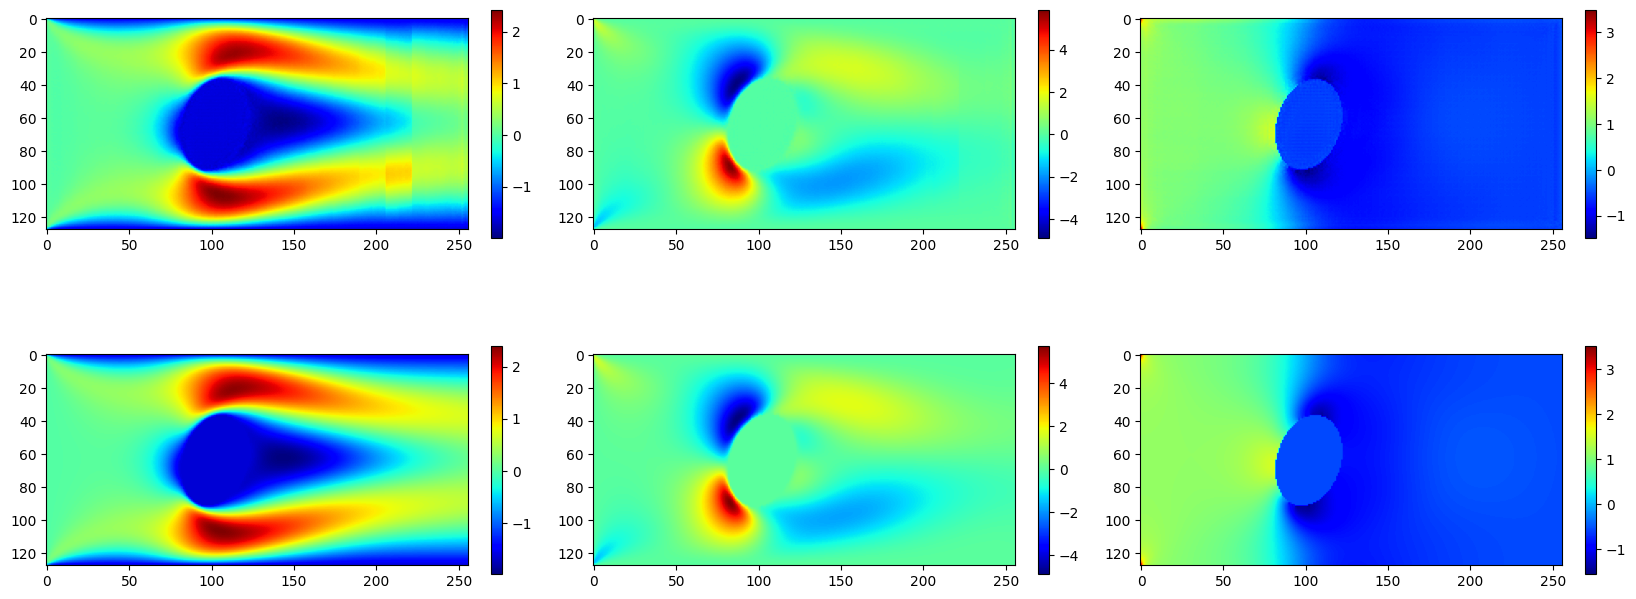

In [ ]:
# Visualizing the predictions and the ground truth data -
plt.figure(figsize = (20, 8))

plt.subplot(2,3,1)
u_pred_img = plt.imshow(u_pred[0], cmap = 'jet')
plt.colorbar(u_pred_img,fraction=0.025, pad=0.05)
plt.subplot(2,3,2)
v_pred_img = plt.imshow(v_pred[0], cmap = 'jet')
plt.colorbar(v_pred_img,fraction=0.025, pad=0.05)
plt.subplot(2,3,3)
p_pred_img = plt.imshow(p_pred[0], cmap = 'jet')
plt.colorbar(p_pred_img,fraction=0.025, pad=0.05)

plt.subplot(2,3,4)
u_img = plt.imshow(y_test[num,:,:,0], cmap = 'jet')
plt.colorbar(u_img,fraction=0.025, pad=0.05)
plt.subplot(2,3,5)
v_img = plt.imshow(y_test[num,:,:,1], cmap = 'jet')
plt.colorbar(v_img,fraction=0.025, pad=0.05)
plt.subplot(2,3,6)
p_img = plt.imshow(y_test[num,:,:,2], cmap = 'jet')
plt.colorbar(p_img,fraction=0.025, pad=0.05)